In [9]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import warnings

warnings.simplefilter('ignore')
%pylab inline

%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
from sklearn.cross_validation import train_test_split


import pandas as pd
from scipy import stats
import numpy as np

import seaborn as sns
from sklearn import datasets
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

Populating the interactive namespace from numpy and matplotlib


## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC

In [3]:
allData = pd.read_csv('data/Kobe.csv')
pd.set_option('display.max_columns', 100)

In [4]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

**На выбросы можно проверять, например, таким образом: сравнивая среднее и медиану, если они значительно отличаются, значит, что выбросы существенные.**

**Проверим некоторые колонки.**

In [5]:
allData.shot_distance.mean(),\
np.median(allData.shot_distance)

(13.437436883083038, 15.0)

In [6]:
allData.lat.mean(),\
np.median(allData.lat)

(33.953192465059175, 33.9703)

**Видно, что разница, в целом, не существенная.**

In [7]:
allData.loc_y.mean(),\
np.median(allData.loc_y)

(91.10753493826758, 74.0)

**Здесь разница уже более заметная, построим гистограмму для того, чтобы понять почему.**

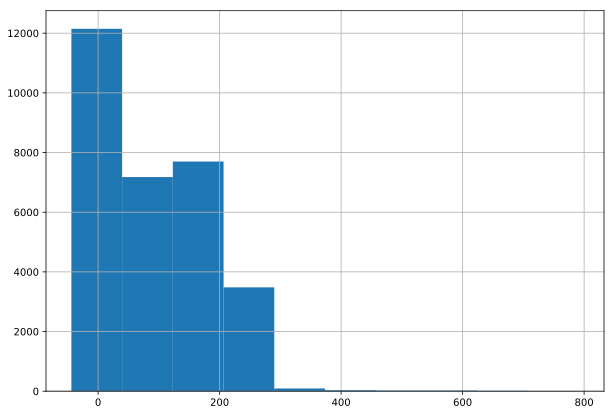

In [10]:
allData.loc_y.hist()

**Видно, что медиана сместилась в сторону более маленьких значений из-за большого скопления показателей в районе 0.**

In [11]:
allData.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [12]:
allData.T.head(8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,30647,30648,30649,30650,30651,30652,30653,30654,30655,30656,30657,30658,30659,30660,30661,30662,30663,30664,30665,30666,30667,30668,30669,30670,30671,30672,30673,30674,30675,30676,30677,30678,30679,30680,30681,30682,30683,30684,30685,30686,30687,30688,30689,30690,30691,30692,30693,30694,30695,30696
action_type,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Driving Dunk Shot,Jump Shot,Layup Shot,Jump Shot,Jump Shot,Running Jump Shot,Jump Shot,Jump Shot,Running Jump Shot,Jump Shot,Jump Shot,Jump Shot,Driving Layup Shot,Jump Shot,Jump Shot,Driving Layup Shot,Jump Shot,Jump Shot,Running Jump Shot,Running Jump Shot,Running Jump Shot,Layup Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Running Jump Shot,Jump Shot,Jump Shot,Jump Shot,Layup Shot,Layup Shot,Reverse Layup Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Layup Shot,Jump Shot,Jump Shot,Layup Shot,Layup Shot,Reverse Dunk Shot,Slam Dunk Shot,Jump Shot,Jump Shot,...,Jump Shot,Jump Shot,Tip Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Layup Shot,Jump Shot,Jump Shot,Jump Shot,Layup Shot,Slam Dunk Shot,Jump Shot,Jump Shot,Jump Shot,Layup Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Running Jump Shot,Driving Layup Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Running Jump Shot,Jump Shot,Driving Layup Shot,Layup Shot,Tip Shot,Jump Shot,Running Jump Shot,Jump Shot,Jump Shot,Jump Shot,Running Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Driving Layup Shot,Jump Shot,Tip Shot,Running Jump Shot,Jump Shot,Jump Shot
combined_shot_type,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Dunk,Jump Shot,Layup,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Layup,Jump Shot,Jump Shot,Layup,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Layup,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Layup,Layup,Layup,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Layup,Jump Shot,Jump Shot,Layup,Layup,Dunk,Dunk,Jump Shot,Jump Shot,...,Jump Shot,Jump Shot,Tip Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Layup,Jump Shot,Jump Shot,Jump Shot,Layup,Dunk,Jump Shot,Jump Shot,Jump Shot,Layup,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Layup,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Layup,Layup,Tip Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Jump Shot,Layup,Jump Shot,Tip Shot,Jump Shot,Jump Shot,Jump Shot
game_event_id,10,12,35,43,155,244,251,254,265,294,309,4,27,66,80,86,100,138,244,249,255,265,274,299,307,332,345,369,400,429,488,499,4,8,26,37,53,165,184,202,212,219,229,233,281,289,295,300,398,410,...,476,480,492,36,57,65,77,81,102,127,130,189,233,238,245,259,270,278,280,295,368,386,425,15,25,29,36,81,84,98,101,181,212,213,218,226,228,231,249,268,284,308,326,331,382,397,398,426,448,471
game_id,20000012,20000012,20000012,20000012,20000012,20000012,20000012,20000012,20000012,20000012,20000012,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000019,20000047,20000047,20000047,20000047,20000047,20000047,20000047,20000047,20000047,20000047,20000047,20000047,20000047,20000047,20000047,20000047,20000047,20000047,...,49900086,49900086,49900086,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900087,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088,49900088
lat,33.9723,34.0443,33.9093,33.8693,34.0443,34.0553,34.0443,34.0163,33.9363,33.9193,33.8063,33.9173,33.9343,34.0403,33.9973,33.852

**Очистим данных от тех строк, где целевая переменна неопределена.**

In [13]:
data = allData[allData['shot_made_flag'].notnull()].reset_index()
сlean_data = allData[allData['shot_made_flag'].notnull()].reset_index()

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25697 entries, 0 to 25696
Data columns (total 26 columns):
index                 25697 non-null int64
action_type           25697 non-null object
combined_shot_type    25697 non-null object
game_event_id         25697 non-null int64
game_id               25697 non-null int64
lat                   25697 non-null float64
loc_x                 25697 non-null int64
loc_y                 25697 non-null int64
lon                   25697 non-null float64
minutes_remaining     25697 non-null int64
period                25697 non-null int64
playoffs              25697 non-null int64
season                25697 non-null object
seconds_remaining     25697 non-null int64
shot_distance         25697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             25697 non-null object
shot_zone_area        25697 non-null object
shot_zone_basic       25697 non-null object
shot_zone_range       25697 non-null object
team_id           

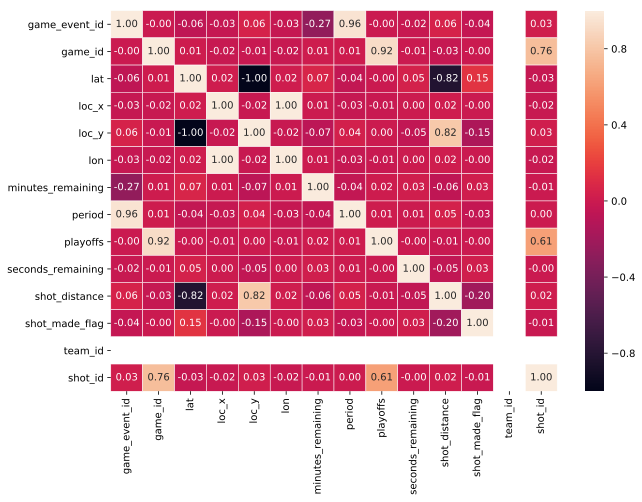

In [15]:
sns.heatmap(allData.corr(), annot=True, fmt=".2f", 
             linewidths=0.5);

**Видно, что, например, loc_x и lon имеют к. корреляции 1. Это говорит нам о том, что они линейно зависимы и можно одну из них удалить. Аналогично для lat и lot_y, period и game_event_id и тд.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B41826C9B0>,
      dtype=object)

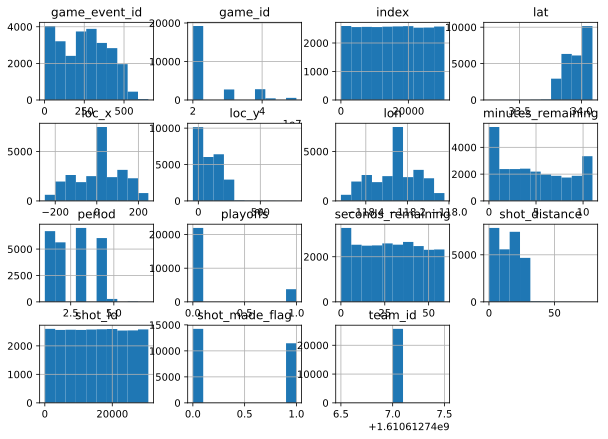

In [16]:
сlean_data.hist()

In [17]:
def get_one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

**Напишем функции, которую будем использовать для визуализации данных.**

In [18]:
def plot_vis(df, col, Normalized, kind, width=1, rot=30):
    
    """
    Функция принимает на вход датафрейм,
    а также колонку по которой происходит группировка. 
    Имеет переменные: 
         1) Normalized == True or False, отвечает за нормализацию данных.
         2) kind = 'bar', 'area', 'line' etc. Отвечает за тип графика. 
         3) width - int. Переменная для 'bar' графика. Отвечает за расстояние между столбцами.
         4) rot - int. Определяет угол, под которым будут расположены названия эл-ов колонок.
         
    На выходе возвращает датафрейм с принятой колонкой и количество элементов этой колонки
    в исходном датафрейме. А также непосредственно визуализацию.
    """
    
    data_col_1 = data[[col, 'shot_made_flag']][data['shot_made_flag']==1].groupby(col).count()
    data_col_0 = data[[col, 'shot_made_flag']][data['shot_made_flag']==0].groupby(col).count()
    data_merged = pd.merge(data_col_1, data_col_0, left_index=True, right_index=True, suffixes=('=1', '=0'), how='right')
    data_merged_clean = data_merged.fillna(0)
    
    if Normalized==True:
        data_merged_clean['sum'] = data_merged_clean['shot_made_flag=1'] + data_merged_clean['shot_made_flag=0']
        data_merged_clean['shot_made_flag=1_n'] = data_merged_clean['shot_made_flag=1']/data_merged_clean['sum']
        data_merged_clean['shot_made_flag=0_n'] = data_merged_clean['shot_made_flag=0']/data_merged_clean['sum']
        
        if kind=='bar':
            return data_merged_clean[['shot_made_flag=1_n', 'shot_made_flag=0_n']].\
                plot(kind=kind, stacked=True, rot=rot, color=['blue', 'red'], width=width), data_merged_clean
        else:
            return data_merged_clean[['shot_made_flag=1_n', 'shot_made_flag=0_n']].\
                plot(kind=kind, stacked=True, rot=rot, color=['blue', 'red']), data_merged_clean
    else:
        if kind=='bar':
            return data_merged_clean.plot(kind=kind, stacked=True, rot=rot, color=['darkgreen', 'darkred'], width=width), data_merged_clean
        else:
            return data_merged_clean.plot(kind=kind, stacked=True, rot=rot, color=['darkgreen', 'darkred']), data_merged_clean

**Покажем некоторые примеры визуализации имеющихся данных.**

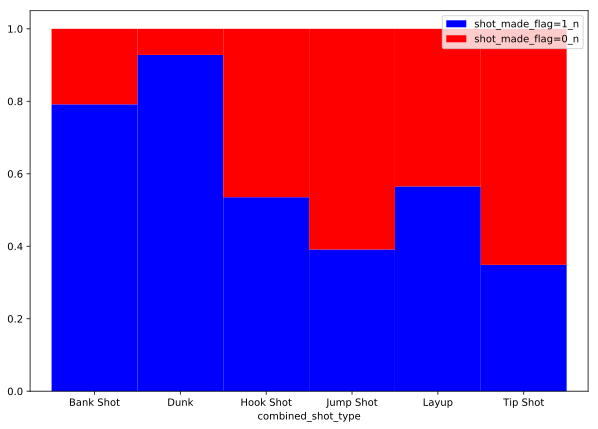

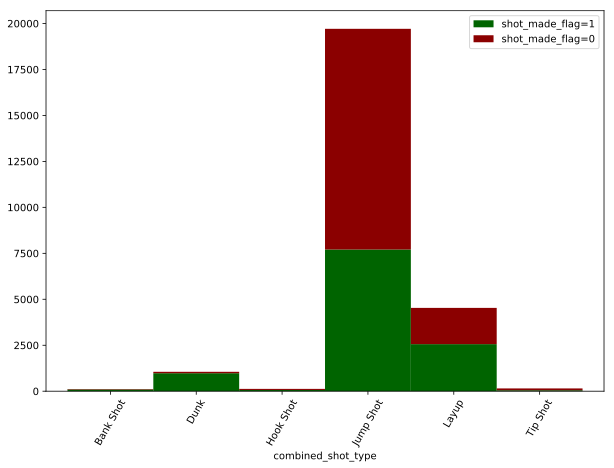

In [19]:
combined_shot_type_df = plot_vis(data, 'combined_shot_type', True, 'bar', width=1, rot=0)
plot_vis(data, 'combined_shot_type', False, 'bar', width=1, rot=60)[0]

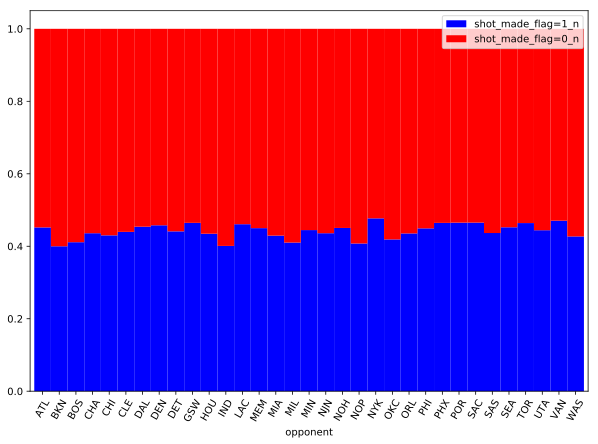

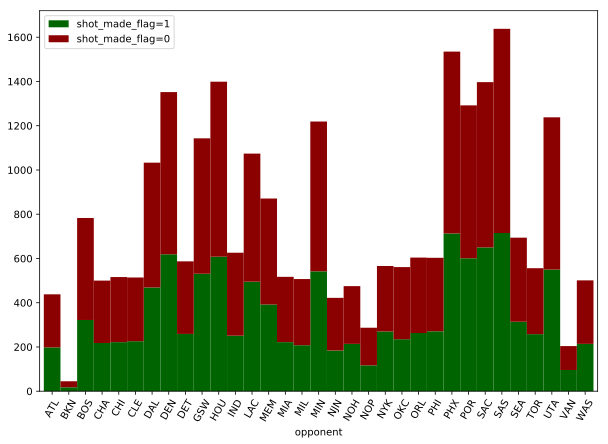

In [20]:
opponent_df = plot_vis(data, 'opponent', True, 'bar', width=1, rot=60)
plot_vis(data, 'opponent', False, 'bar', width=1, rot=60)[0]

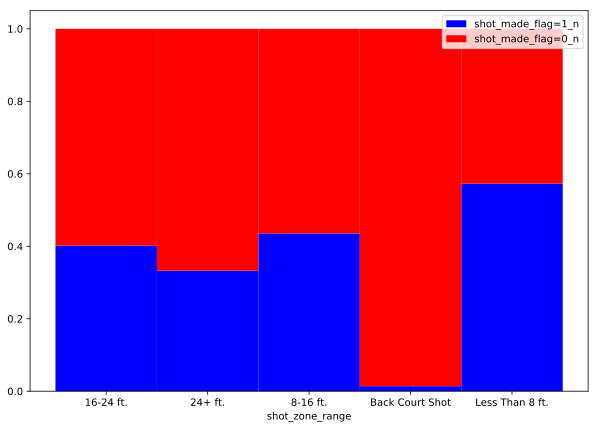

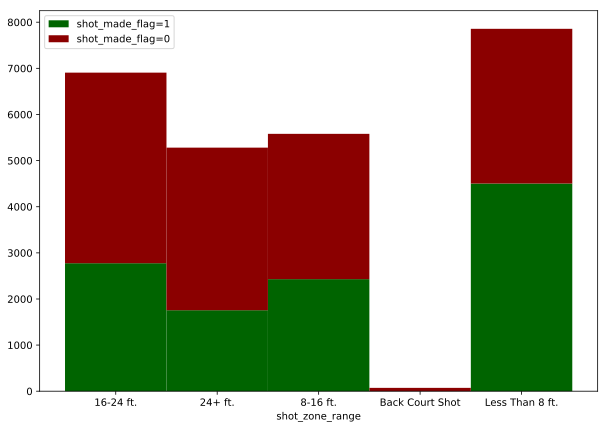

In [21]:
shot_zone_range_df = plot_vis(data, 'shot_zone_range', True, 'bar', width=1, rot=0)
plot_vis(data, 'shot_zone_range', False, 'bar', width=1, rot=0)[0]

**Видно, например, что броски с зоны "Back count shot" были крайне редки и крайне неудачны.**

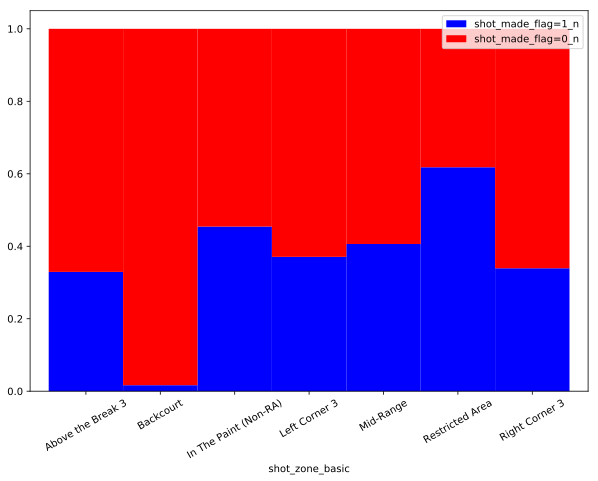

In [22]:
shot_zone_basic_df = plot_vis(data, 'shot_zone_basic', True, 'bar', width=1, rot=30)

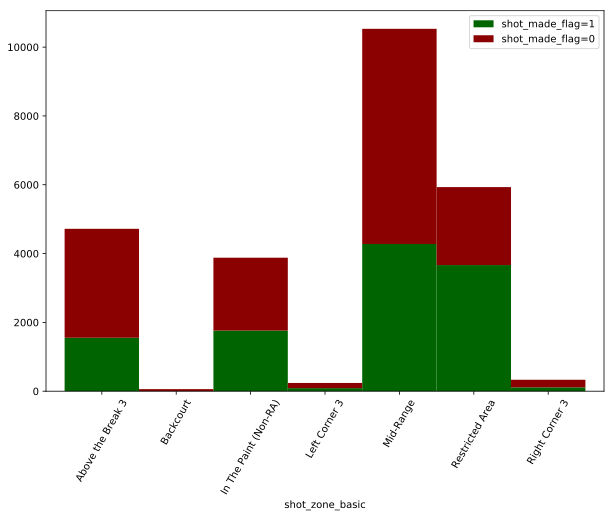

In [23]:
plot_vis(data, 'shot_zone_basic', False, 'bar', width=1, rot=60)[0]

Text(0,0.5,'Normalized Count')

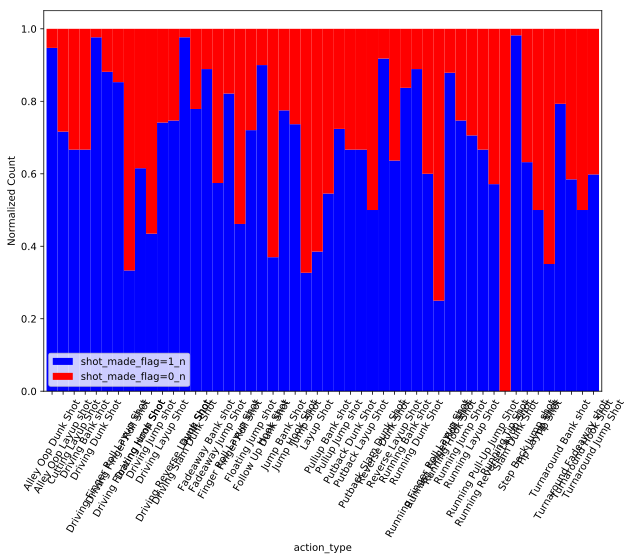

In [24]:
action_type_df = plot_vis(data, 'action_type', True, 'bar', width=1, rot=60)
plt.ylabel('Normalized Count')

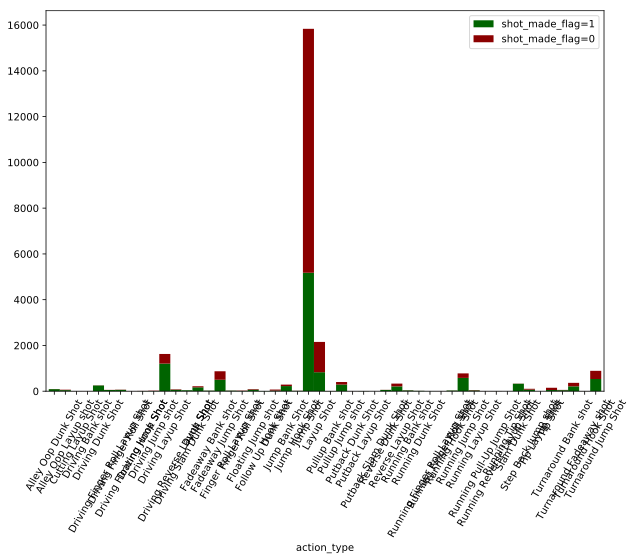

In [25]:
plot_vis(df=data, col='action_type', Normalized=False, kind='bar', rot=60)[0]

In [26]:
data_action_type = data[['shot_id', 'action_type']].groupby('action_type').count().sort_values('shot_id', ascending=False)

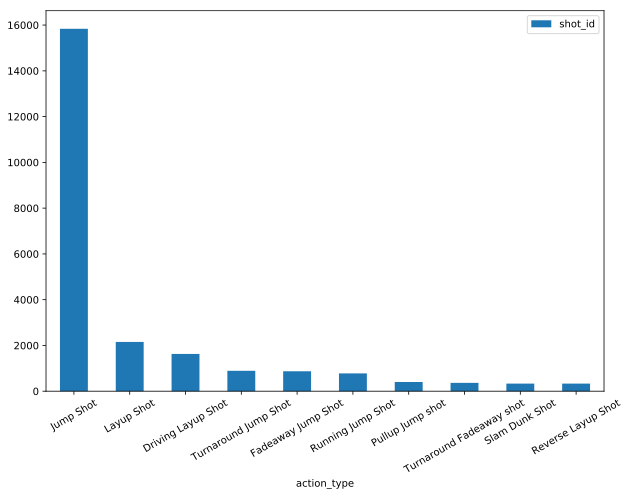

In [27]:
data_action_type[:10].plot(kind='bar', rot=30)

**Можем также изобразить карту бросков нашего игрока.**

Text(0.5,1,'lat and lon')

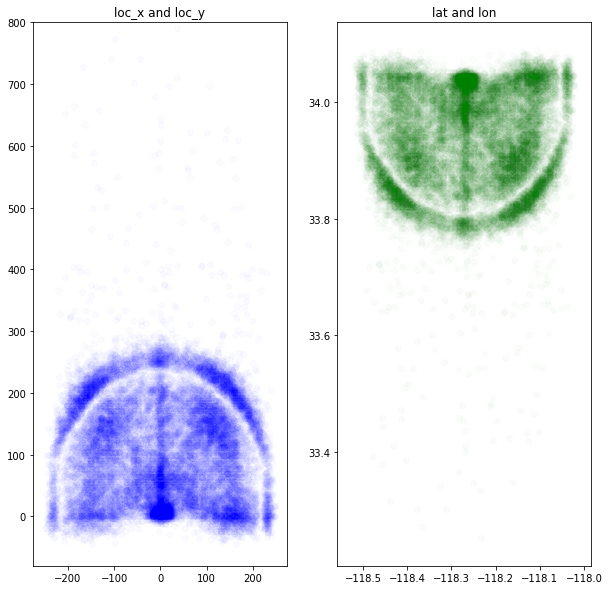

In [28]:
%config InlineBackend.figure_format = 'png' 
alpha = 0.02
plt.figure(figsize=(10,10))

# loc_x and loc_y
plt.subplot(121)
plt.scatter(data.loc_x, data.loc_y, color='blue', alpha=alpha)
plt.title('loc_x and loc_y')
plt.ylim(-80,800)

# lat and lon
plt.subplot(122)
plt.scatter(data.lon, data.lat, color='green', alpha=alpha)
plt.title('lat and lon')

In [29]:
%config InlineBackend.figure_format = 'svg' 

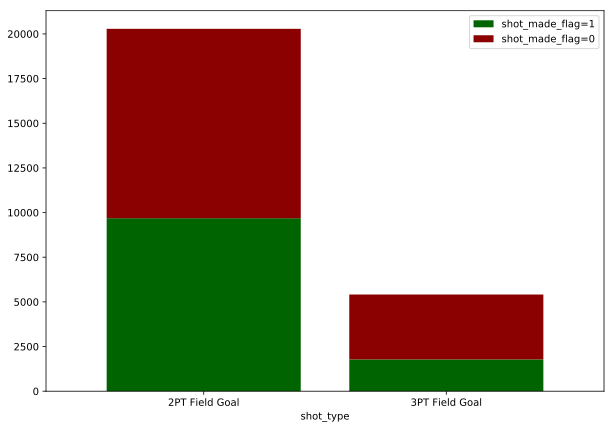

In [30]:
plot_vis(data, 'shot_type', False, 'bar', width=0.8, rot=0)[0]

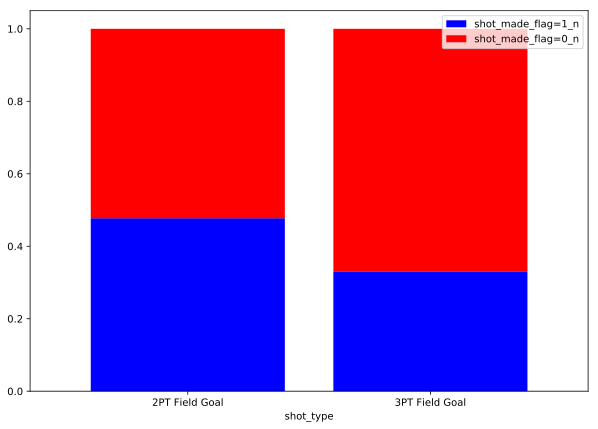

In [31]:
shot_type_df = plot_vis(data, 'shot_type', True, 'bar', width=0.8, rot=0)

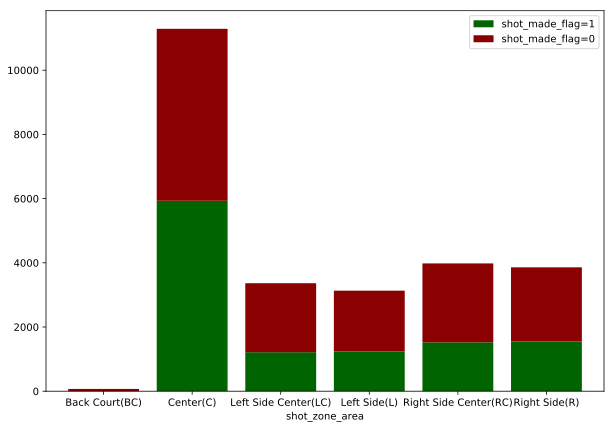

In [32]:
plot_vis(data, 'shot_zone_area', False, 'bar', width=0.8, rot=0)[0]

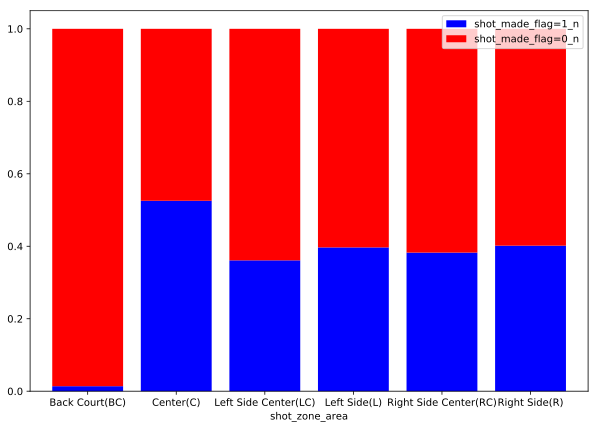

In [33]:
shot_zone_area_df = plot_vis(data, 'shot_zone_area', True, 'bar', width=0.8, rot=0)

Text(0.5,1,'shot_zone_range')

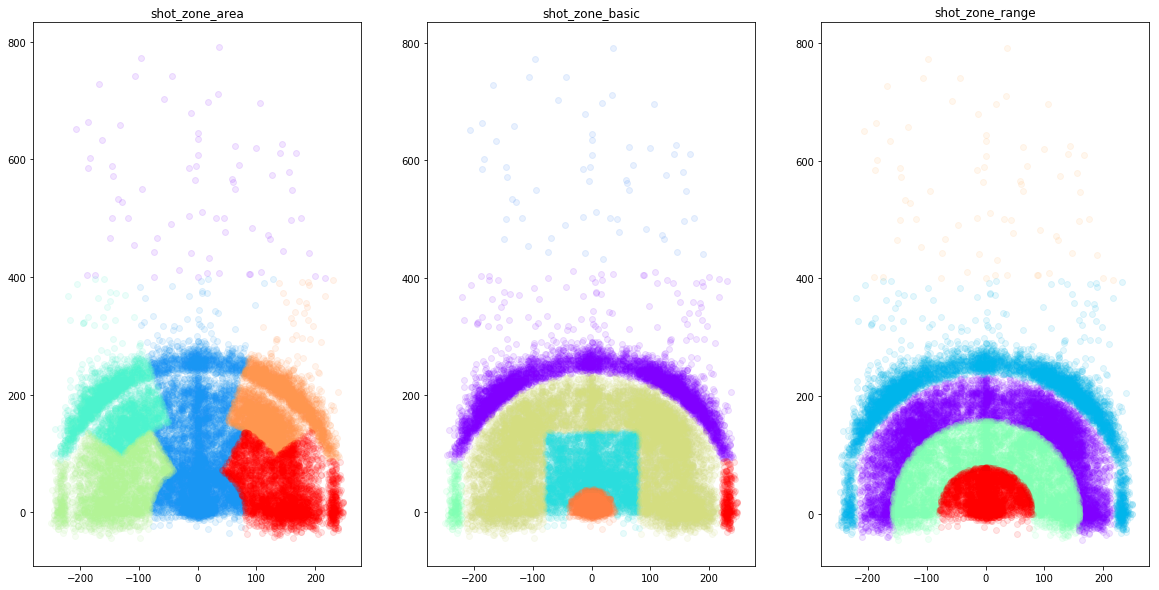

In [34]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))
%config InlineBackend.figure_format = 'png' 


def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = data.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

plt.subplot(132)
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

plt.subplot(133)
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')

In [35]:
%config InlineBackend.figure_format = 'svg' 

**В нашем датасете имеется два столбца - seconds_remaining и minutes_remaining, говорящие о времени которое осталось до конца игры, объединим их в time_remaining (размерность - секунды)**

In [36]:
data['time_remaining'] = data.seconds_remaining + data.minutes_remaining*60
data_time_remaining = data[['time_remaining', 'shot_made_flag']].groupby('time_remaining').count()
data_time_remaining = data_time_remaining.rename(columns={'shot_made_flag':'count'})

(0, 100)

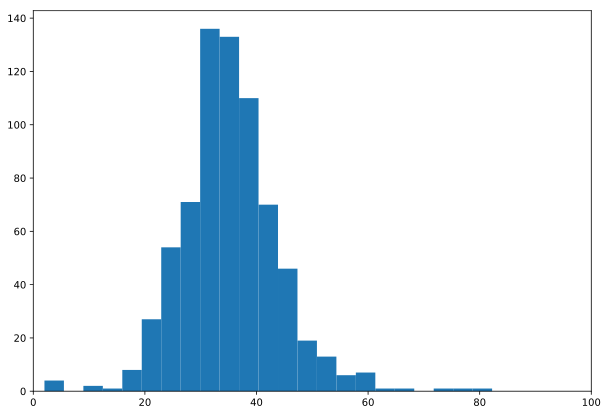

In [37]:
plt.hist(list(data_time_remaining['count']), bins=125)
plt.xlim(0,100)

In [38]:
data_time_remaining = data_time_remaining.reset_index()

In [39]:
x = data_time_remaining['count']

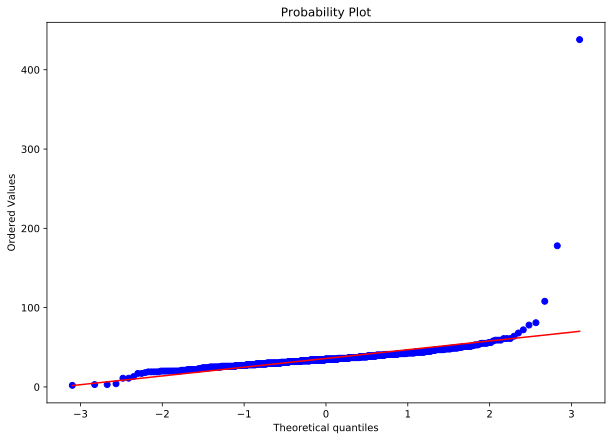

In [40]:
res = stats.probplot(x, plot=plt, dist='norm')

**Видно, что параметр time_remaining имеет почти в точности нормальное распределение.**

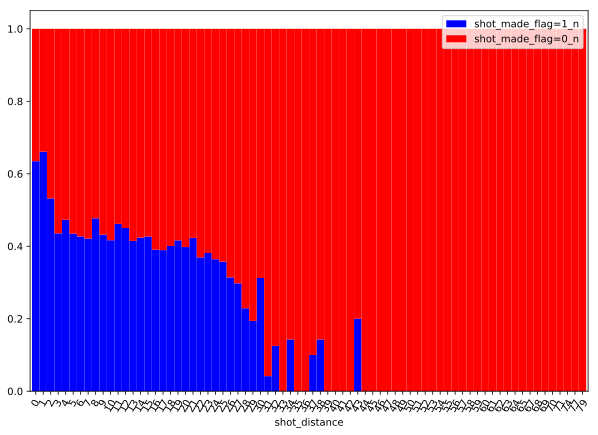

In [41]:
shot_distance_df = plot_vis(data, 'shot_distance', True, 'bar', width=1, rot=60)

(0, 40)

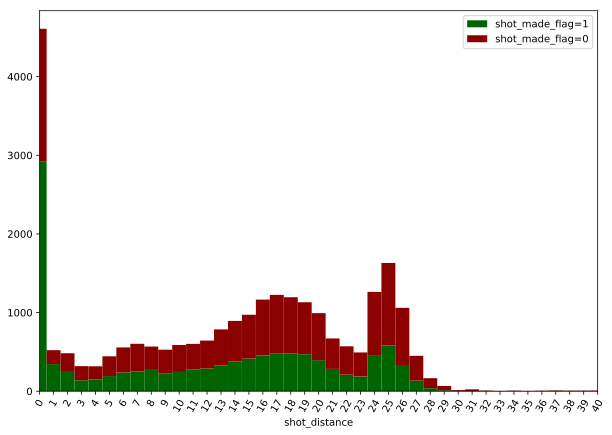

In [42]:
shot_distance_df = plot_vis(data, 'shot_distance', False, 'bar', width=1, rot=60)
plt.xlim(0, 40)

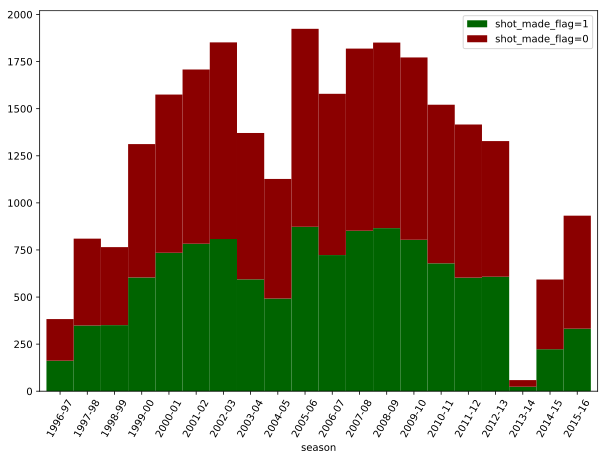

In [43]:
plot_vis(data, 'season', False, 'bar', width=1, rot=60)[0]

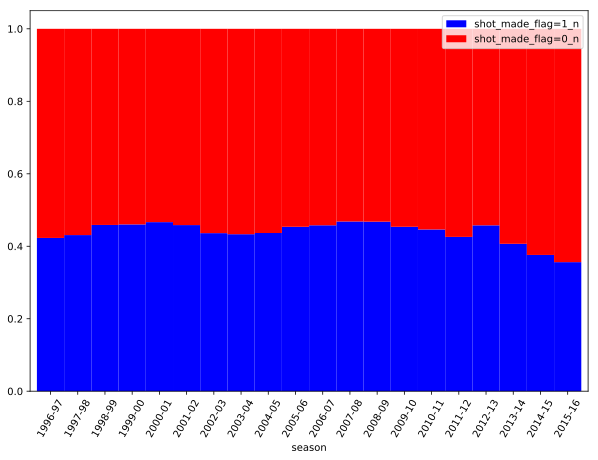

In [44]:
plot_vis(data, 'season', True, 'bar', width=1, rot=60)[0]

**Построим модель используя просто get_dummies.**

In [45]:
from sklearn.metrics import roc_auc_score, roc_curve
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost
from sklearn.linear_model import LogisticRegression

In [46]:
df_train = сlean_data.drop(['shot_id'], axis=1)
df_train_y = сlean_data[['shot_id', 'shot_made_flag']].set_index('shot_id')
df_train = df_train.drop(['shot_made_flag'], axis=1)
df_train = pd.get_dummies(df_train)

In [47]:
df_train.shape

(25697, 1780)

In [48]:
clf = LogisticRegression()
X_train = df_train.iloc[:, 23:]
y_train = df_train_y['shot_made_flag']

In [49]:
clf.fit(X=X_train, y=y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
y_train_predict = clf.predict_proba(X_train)[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 9)
print("Train: ", round(roc_auc_train, 2))

Train:  0.75


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

clf = LogisticRegression() # use any model

scores = cross_validate(
    clf, X_train, y_train, cv=5, scoring=('roc_auc', 'accuracy', 'f1', 'precision'), return_train_score=True
)
scores

{'fit_time': array([0.67120576, 0.69813442, 0.80684304, 0.71412277, 0.66721511]),
 'score_time': array([0.16954637, 0.17054296, 0.20046329, 0.17150831, 0.17154193]),
 'test_accuracy': array([0.66906615, 0.66303502, 0.63144581, 0.64273205, 0.66588831]),
 'test_f1': array([0.55691586, 0.52883569, 0.54361446, 0.50243902, 0.55529656]),
 'test_precision': array([0.69146184, 0.70281996, 0.60743134, 0.66356478, 0.68367347]),
 'test_roc_auc': array([0.66781982, 0.64918949, 0.61268292, 0.61015376, 0.68233401]),
 'train_accuracy': array([0.69786447, 0.69737802, 0.7048351 , 0.69958167, 0.69821967]),
 'train_f1': array([0.6030549 , 0.60524145, 0.61012593, 0.60165119, 0.60271516]),
 'train_precision': array([0.72864865, 0.72400182, 0.7428035 , 0.73657612, 0.73029174]),
 'train_roc_auc': array([0.75313994, 0.75651468, 0.76025357, 0.75704932, 0.75386321])}

**Проверку на тестовых данных мы будем производить с помощью кросс-валидации. В данном случае, мы видим довольно значительное падение точности на тесте.**

**Теперь постараемся увеличить точность модели.**

In [52]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['shot_id', col_to_groupby, 'shot_made_flag']].groupby(['shot_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

**Выберем основные колонки, по которым мы булем делать наши фичи.**

In [53]:
columns = ['action_type', 'game_event_id', 'loc_x', 'loc_y', 'game_date', 'shot_distance', 'combined_shot_type',
           'season', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'opponent', 'time_remaining']

In [54]:
dfs = []

for column in columns:
    df = get_aggregated_df(data, agg_type='count', col_to_groupby=column)
    dfs.append(df)

In [55]:
data = data.set_index('shot_id')

In [56]:
for df in dfs:
    print(df.shape)

(25697, 55)
(25697, 618)
(25697, 486)
(25697, 446)
(25697, 1558)
(25697, 74)
(25697, 6)
(25697, 20)
(25697, 2)
(25697, 6)
(25697, 7)
(25697, 5)
(25697, 33)
(25697, 715)


In [54]:
for df in dfs:
    train_df = pd.merge(data, df, left_index=True, right_index=True, how='inner')
    data = train_df

In [55]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [56]:
train_df = train_df.drop(train_df.columns[:25], axis=1)

In [57]:
Columns = pd.io.parsers.ParserBase({'names':train_df.columns})._maybe_dedup_names(train_df.columns)

In [58]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 2 to 30697
Columns: 4032 entries, time_remaining to time_remaining_count_714
dtypes: int64(4032)
memory usage: 791.9 MB


**Мы получили достаточно много фичей, для начала проверим модель используя все фичи, но потом произведем сокращение размерности данных.**

In [59]:
x = train_df
y = df_train_y['shot_made_flag']
X_train, X_test, y_train, y_test = train_test_split(x, y,stratify=y, test_size=0.2, random_state=42)

In [60]:
from sklearn.metrics import roc_auc_score, roc_curve

In [61]:
clf = LogisticRegression()
clf.fit(X=X_train, y=y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
y_train_predict = clf.predict_proba(X_train)[:, 1]
y_test_predict =  clf.predict_proba(X_test)[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 9)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 9)

print("Train: ", round(roc_auc_train, 2))
print("Test: ", round(roc_auc_test, 2))

Train:  0.83
Test:  0.66


**Видно, что на тесте заметно падает точность, постараемся исправить это, уменьшив кол-во фич**

In [63]:
scores = cross_validate(
    clf, X_train, y_train, cv=5, scoring=('roc_auc', 'accuracy', 'f1', 'precision'), return_train_score=True
)
scores

{'fit_time': array([2.9335463 , 1.93055177, 1.93238115, 1.86099815, 1.75223851]),
 'score_time': array([0.42787099, 0.35016227, 0.47221208, 0.34308243, 0.33110118]),
 'test_accuracy': array([0.62986381, 0.63594358, 0.64096327, 0.62709803, 0.63488202]),
 'test_f1': array([0.55807201, 0.5551263 , 0.56842105, 0.56187482, 0.56302766]),
 'test_precision': array([0.59726538, 0.61045752, 0.61286255, 0.59039039, 0.6039975 ]),
 'test_roc_auc': array([0.65869452, 0.66514188, 0.67226674, 0.65223354, 0.6582771 ]),
 'train_accuracy': array([0.76260261, 0.76260261, 0.76054968, 0.76602213, 0.76121853]),
 'train_f1': array([0.71374102, 0.71272995, 0.71099369, 0.71920607, 0.71182212]),
 'train_precision': array([0.77241708, 0.77450824, 0.77035623, 0.77411247, 0.77118779]),
 'train_roc_auc': array([0.84307846, 0.84221844, 0.84204959, 0.84756098, 0.84438445])}

**Теперь мы получили площать под roc-кривой 0.83, что несколько лучше предыдущего результата, но на тесте результат неудовлетворительный.**

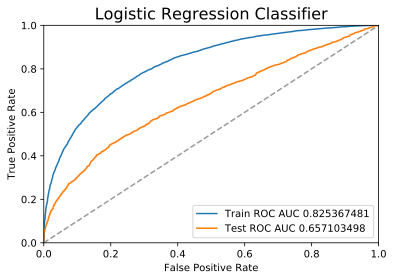

In [64]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

**С помощью Ridge уберем те фичи, чьи коэф. меньше $4е-3$.**

In [65]:
X = X_train.as_matrix()
y = y_train

rg = Ridge(alpha=1000).fit(X, y)
coefs = np.array(rg.coef_)
columns_coefs = dict(zip(Columns, coefs))

k = 0
to_drop_columns = []
for coefs in columns_coefs.items():
    if abs(coefs[1]) < 4e-3:
        to_drop_columns.append(coefs[0])
        k+=1
        
train_df1 = train_df.drop(columns=to_drop_columns)

In [66]:
x = train_df1
y = df_train_y['shot_made_flag']
X_train1, X_test1, y_train1, y_test1 = train_test_split(x, y,stratify=y, test_size=0.2, random_state=42)

In [67]:
clf = LogisticRegression()
clf.fit(X=X_train1, y=y_train1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [68]:
y_train_predict1 = clf.predict_proba(X_train1)[:, 1]
y_test_predict1 =  clf.predict_proba(X_test1)[:, 1]

roc_auc_train1 = np.round(roc_auc_score(y_train1, y_train_predict1), 9)
roc_auc_test1 = np.round(roc_auc_score(y_test1, y_test_predict1), 9)

print("Train: ", round(roc_auc_train1, 2))
print("Test: ", round(roc_auc_test1, 2))

Train:  0.75
Test:  0.68


In [69]:
train_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 2 to 30697
Columns: 393 entries, action_type_count_Alley Oop Dunk Shot to time_remaining_count_677
dtypes: int64(393)
memory usage: 78.5 MB


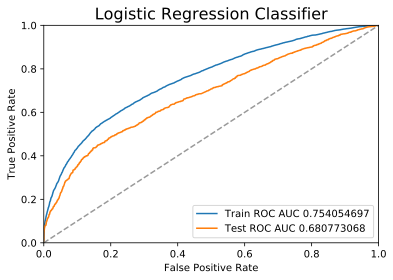

In [70]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train1, y_train_predict1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test1, y_test_predict1)

plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train1))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test1))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [71]:
scores = cross_validate(
    clf, X_train1, y_train, cv=5, scoring=('roc_auc', 'accuracy', 'f1', 'precision'), return_train_score=True
)
scores

{'fit_time': array([0.18550348, 0.17652702, 0.17253804, 0.17653656, 0.18450665]),
 'score_time': array([0.03690195, 0.03789902, 0.03690219, 0.03988481, 0.03989339]),
 'test_accuracy': array([0.68433852, 0.6875    , 0.69374848, 0.68328874, 0.68985648]),
 'test_f1': array([0.59386733, 0.59450931, 0.60545284, 0.59640422, 0.5974108 ]),
 'test_precision': array([0.69728141, 0.70614693, 0.71186441, 0.69109195, 0.70967742]),
 'test_roc_auc': array([0.72957271, 0.73924077, 0.74032918, 0.72742503, 0.72264894]),
 'train_accuracy': array([0.70525996, 0.70367893, 0.70254165, 0.70612915, 0.70284568]),
 'train_f1': array([0.6207652 , 0.61849213, 0.61498505, 0.62227433, 0.61679605]),
 'train_precision': array([0.72869214, 0.72663723, 0.72783159, 0.72952172, 0.72631579]),
 'train_roc_auc': array([0.75698   , 0.75406517, 0.7547338 , 0.7576491 , 0.75816562])}

**Таким образом, мы уменьшили количество фичей практически в 10 раз, но точность модели несколько уменьшилась. Постараемся убрать совсем ничего не значащие фичи.**

In [72]:
X = X_train.as_matrix()
y = y_train

rg = Ridge(alpha=1000).fit(X, y)
coefs = np.array(rg.coef_)
columns_coefs = dict(zip(Columns, coefs))

k = 0
to_drop_columns = []
for coefs in columns_coefs.items():
    if abs(coefs[1]) < 1.45e-3:
        to_drop_columns.append(coefs[0])
        k+=1
        
train_df2 = train_df.drop(columns=to_drop_columns)

In [73]:
x = train_df2
y = df_train_y['shot_made_flag']
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [74]:
clf = LogisticRegression()
clf.fit(X=X_train2, y=y_train2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [75]:
y_train_predict2 = clf.predict_proba(X_train2)[:, 1]
y_test_predict2 =  clf.predict_proba(X_test2)[:, 1]

roc_auc_train2 = np.round(roc_auc_score(y_train2, y_train_predict2), 9)
roc_auc_test2 = np.round(roc_auc_score(y_test2, y_test_predict2), 9)

print("Train: ", round(roc_auc_train2, 2))
print("Test: ", round(roc_auc_test2, 2))

Train:  0.81
Test:  0.66


In [76]:
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 2 to 30697
Columns: 1863 entries, action_type_count_Alley Oop Dunk Shot to time_remaining_count_708
dtypes: int64(1863)
memory usage: 366.7 MB


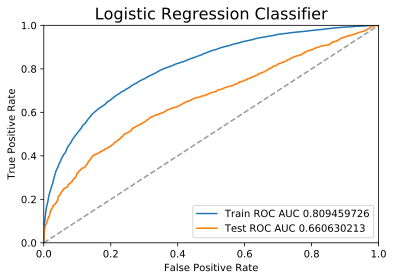

In [77]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train2, y_train_predict2)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test2, y_test_predict2)

plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train2))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test2))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [78]:
scores = cross_validate(
    clf, X_train2, y_train2, cv=5, scoring=('roc_auc', 'accuracy', 'f1', 'precision'), return_train_score=True
)
scores

{'fit_time': array([0.78390217, 0.89361024, 0.8338089 , 1.12000394, 0.84177589]),
 'score_time': array([0.19148779, 0.19248486, 0.16152978, 0.1765275 , 0.16951847]),
 'test_accuracy': array([0.67728599, 0.6743677 , 0.68134274, 0.67477499, 0.67404524]),
 'test_f1': array([0.60541183, 0.59485628, 0.61081402, 0.60618557, 0.59735577]),
 'test_precision': array([0.66623037, 0.66870748, 0.67101828, 0.65919283, 0.66532798]),
 'test_roc_auc': array([0.72088388, 0.72598392, 0.73613787, 0.71659653, 0.71147622]),
 'train_accuracy': array([0.74466403, 0.74508969, 0.74170011, 0.74486197, 0.74778062]),
 'train_f1': array([0.68796909, 0.68739746, 0.68274832, 0.68802974, 0.69187342]),
 'train_precision': array([0.75637255, 0.75893298, 0.75528751, 0.75703534, 0.76045069]),
 'train_roc_auc': array([0.81773748, 0.81732113, 0.81605961, 0.82085187, 0.82081323])}

**Таким образом, мы убрали половину фичей, точность нашей модели на трейне практически не изменилась, а показатели на тесте улучшились.**

In [79]:
rss = np.sum((y_train_predict - y_train) ** 2)
print("RSS:", rss)

RSS: 3492.232643840861


In [80]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [81]:
X = X_train.as_matrix()
y = y_train

In [82]:
lm = LinearRegression().fit(X, y)
print(lm.intercept_)
print(lm.coef_)

-1428644189.2017367
[ 2.24177990e-05 -8.94804354e+07 -3.06273650e+07 ...  9.62530311e+06
  9.62530266e+06  9.62530314e+06]


In [83]:
rg = Ridge(alpha=1000).fit(X, y)
print(rg.intercept_)
print(rg.coef_)

0.586489053195462
[ 5.64370001e-05  1.13302820e-02  3.44400597e-03 ...  4.86574402e-04
 -1.03526256e-03  2.43700437e-04]


In [84]:
ls = Lasso(alpha=0.00001).fit(X, y)
print(ls.intercept_)
print(ls.coef_)

0.5617623723162638
[ 3.31786758e-05  3.73581246e-03  0.00000000e+00 ...  1.35733747e-02
 -2.44030601e-01  3.83577421e-02]


In [85]:
X = X_train.as_matrix()
X1 = X_train1.as_matrix()
X2 = X_train2.as_matrix()

In [86]:
lm1 = LinearRegression().fit(X1,y)
rg1 = Ridge(alpha=1000).fit(X1, y)
ls1 = Lasso(alpha=0.0005).fit(X1, y)

In [87]:
lm2 = LinearRegression().fit(X2,y)
rg2 = Ridge(alpha=1000).fit(X2, y)
ls2 = Lasso(alpha=0.0005).fit(X2, y)

**Посчитаем RSS для каждого набора фич, а также для каждого классификатора.**

In [88]:
rss_lm = np.sum((lm.predict(X)) ** 2)
rss_rg = np.sum((rg.predict(X)) ** 2)
rss_ls = np.sum((ls.predict(X)) ** 2)

In [89]:
rss_lm1 = np.sum((lm1.predict(X1) - y) ** 2)
rss_rg1 = np.sum((rg1.predict(X1) - y) ** 2)
rss_ls1 = np.sum((ls1.predict(X1) - y) ** 2)

In [90]:
rss_lm2 = np.sum((lm2.predict(X2) - y) ** 2)
rss_rg2 = np.sum((rg2.predict(X2) - y) ** 2)
rss_ls2 = np.sum((ls2.predict(X2) - y) ** 2)

In [91]:
rss_lm, rss_rg, rss_ls

(5698.998224380063, 4529.267798325355, 5551.053580597875)

In [92]:
rss_lm1, rss_rg1, rss_ls1

(4045.8259637905285, 4377.422572648043, 4298.280009240083)

In [93]:
rss_lm2, rss_rg2, rss_ls2

(3635.7576484680176, 4359.122812471875, 4296.427279257524)

**Видно, что наименьшие RSS у третьего набора фич.**

**Построим сравнительную таблицу коэф-ов.**

In [94]:
rg_coefs = np.array(rg.coef_)
ls_coefs = np.array(ls.coef_)
lm_coefs = np.array(lm.coef_)

columns_lm_coefs = dict(zip(Columns, lm_coefs))
columns_rg_coefs = dict(zip(Columns, rg_coefs))
columns_ls_coefs = dict(zip(Columns, ls_coefs))

In [95]:
columns_lm_coefs = pd.DataFrame([columns_lm_coefs])
columns_rg_coefs = pd.DataFrame([columns_rg_coefs])
columns_ls_coefs = pd.DataFrame([columns_ls_coefs])

In [96]:
coefs = pd.concat([columns_lm_coefs, columns_rg_coefs, columns_ls_coefs], axis=0, ignore_index=True)

In [97]:
coefs = coefs.rename({0: 'Logistic Regression', 1: 'Ridge', 2: 'Lasso'}, axis='index')

In [98]:
coefs = coefs.T

In [99]:
coefs[:15]

,Logistic Regression,Ridge,Lasso
action_type_count_Alley Oop Dunk Shot,-8.948044e+07,0.011330,0.003736
action_type_count_Alley Oop Layup shot,-3.062737e+07,0.003444,0.000000
action_type_count_Cutting Layup Shot,-3.062737e+07,0.000119,-0.039126
action_type_count_Driving Bank shot,-7.262100e+07,-0.000266,-0.056275
action_type_count_Driving Dunk Shot,-8.948044e+07,0.032345,0.044004
action_type_count_Driving Finger Roll Layup Shot,-3.062736e+07,0.010699,0.198544
action_type_count_Driving Finger Roll Shot,-3.062736e+07,0.009535,0.150996
action_type_count_Driving Floating Bank Jump Shot,-3.822241e+07,0.000464,0.246620
action_type_count_Driving Floating Jump Shot,-3.822241e+07,-0.000574,0.000000
action_type_count_Driving Hook Shot,-1.444356e+08,-0.000366,0.000000


**Видно, что Ridge заметно уменьшает коэффициенты, при этом Lasso и вовсе многие коэффициенты обнуляет (какие - зависит от параметра alpha)** 

**Теперь обучим модель используя Ridge и Lasso классификаторы и сравним их точность.**

**RIDGE**

In [100]:
from sklearn.linear_model import RidgeClassifier

In [101]:
clf_rg = RidgeClassifier().fit(X_train, y_train)

scores_rg = cross_validate(
    clf_rg, X_train, y_train, cv=5, scoring=('roc_auc', 'accuracy', 'f1', 'precision'), return_train_score=True
)
scores_rg

{'fit_time': array([4.96372557, 5.82043505, 6.06777358, 4.60169458, 5.48632908]),
 'score_time': array([0.34208512, 0.52659082, 0.34308171, 0.38596749, 0.38498068]),
 'test_accuracy': array([0.61551556, 0.62864786, 0.63099003, 0.61298954, 0.61809779]),
 'test_f1': array([0.55046915, 0.55700609, 0.56269818, 0.55043798, 0.54807139]),
 'test_precision': array([0.57550535, 0.5955335 , 0.5969419 , 0.571261  , 0.5804878 ]),
 'test_roc_auc': array([0.64148127, 0.65132692, 0.65586571, 0.63683203, 0.64510546]),
 'train_accuracy': array([0.77032533, 0.77111584, 0.7668734 , 0.77185942, 0.77216344]),
 'train_f1': array([0.72620515, 0.72669184, 0.72189177, 0.73038229, 0.72955612]),
 'train_precision': array([0.77562713, 0.77762238, 0.77171216, 0.77257525, 0.7755102 ]),
 'train_roc_auc': array([0.84978854, 0.84871979, 0.84841913, 0.85405609, 0.85060513])}

**LASSO**

In [102]:
y_train_predict = ls.predict(X_train)
y_test_predict = ls.predict(X_test)

In [103]:
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 9)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 9)

print("Train: ", round(roc_auc_train, 6))
print("Test: ", round(roc_auc_test, 6))

Train:  0.828722
Test:  0.648912


**На трейне результата заметно выше, что вероятно, связано с переобучением модели.**

**Получили: roc_auc_train для $LinReg = 0.8253, Ridge = 0.8199, Lasso = 0.8287$**

**Напоследок можно также обучить модели с помощью град. бустинга для трех наборов фич.**

In [104]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)

In [105]:
x = train_df
y = df_train_y['shot_made_flag']
X_train, X_test, y_train, y_test = train_test_split(x, y,stratify=y, test_size=0.2, random_state=42)

In [106]:
xgb.fit(X_train, y_train)
y_train_predict = xgb.predict_proba(X_train)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)

xgb.fit(X_test, y_test)
y_test_predict = xgb.predict_proba(X_test)[:, 1]
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)

print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.75
Test:  0.79


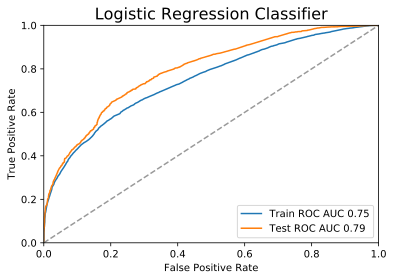

In [107]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [109]:
x = train_df1
y = df_train_y['shot_made_flag']
X_train1, X_test1, y_train1, y_test1 = train_test_split(x, y,stratify=y, test_size=0.2, random_state=42)

In [110]:
xgb.fit(X_train1, y_train1)
y_train_predict1 = xgb.predict_proba(X_train1)[:, 1]
roc_auc_train1 = np.round(roc_auc_score(y_train1, y_train_predict1), 2)

xgb.fit(X_test1, y_test1)
y_test_predict1 = xgb.predict_proba(X_test1)[:, 1]
roc_auc_test1 = np.round(roc_auc_score(y_test1, y_test_predict1), 2)

print("Train: ", roc_auc_train1)
print("Test: ", roc_auc_test1)

Train:  0.74
Test:  0.75


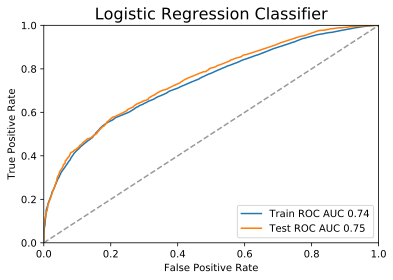

In [111]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train1, y_train_predict1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test1, y_test_predict1)

plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train1))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test1))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [113]:
x = train_df2
y = df_train_y['shot_made_flag']
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y,stratify=y, test_size=0.2, random_state=42)

In [114]:
xgb.fit(X_train2, y_train2)
y_train_predict2 = xgb.predict_proba(X_train2)[:, 1]
roc_auc_train2 = np.round(roc_auc_score(y_train2, y_train_predict2), 2)

xgb.fit(X_test2, y_test2)
y_test_predict2 = xgb.predict_proba(X_test2)[:, 1]
roc_auc_test2 = np.round(roc_auc_score(y_test2, y_test_predict2), 2)

print("Train: ", roc_auc_train2)
print("Test: ", roc_auc_test2)

Train:  0.74
Test:  0.78


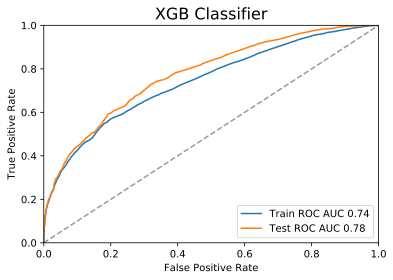

In [115]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train2, y_train_predict2)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test2, y_test_predict2)

plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train2))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test2))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()